# Experiments (MLflow) Tutorial

This `experiment.ipynb` Jupyter notebook shows an example of how you can use the Experiments feature to train and compare models.

In this tutorial, you will:
* train several support vector machine models to classify handwritten digits
* create an experiment using MLflow
* create runs within an experiment using MLflow
* persist parameters, metrics, and artifacts that ensure reproducibility and enable visual comparison of models

## Attribution
* Some code is adapted from [sklearn's tutorial for "Recognizing hand-written digits"](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)
* Inspriation for the structure of the experiment and runs taken from [mlflow's sklearn_elasticnet_wine example](https://github.com/mlflow/mlflow/blob/master/examples/sklearn_elasticnet_wine/train.ipynb)

In [ ]:
#Create AWS_CONFIG_FILE
#Emulate Side-Car
import requests
import os


#Get Access Token
access_token_endpoint='http://localhost:8899/access-token'
resp = requests.get(access_token_endpoint)
token = resp.text

# Get AWS Config File
os.environ['SSL_CERT_DIR']='/etc/ssl/certs/irsa'
headers = {
             "Content-Type": "application/json",
             "Authorization": "Bearer " + token,
        }
endpoint='https://irsa-svc.domino-field/map_iam_roles_to_pod_sa'
print(f"Domino Run Id{os.environ['DOMINO_RUN_ID']}")
data = {"run_id": os.environ['DOMINO_RUN_ID'], "irsa_workload_type":"cluster-edge"} ## It fetches this fom the downward api
resp = requests.post(endpoint,headers=headers,json=data,verify=False)

# Write the AWS Config file contents to the AWS_CONFIG_FILE location
aws_config_file_contents=''
if resp.status_code == 200:
    aws_config_file_contents=resp.text
    print('Write to config file')
    config_file = os.environ["AWS_CONFIG_FILE"]
    with open(config_file, "w") as f:
        f.write(resp.content.decode())

In [18]:
# License for code in this notebook: BSD 3 clause
# import everything we'll need for the rest of the notebook
import os
from copy import copy
from itertools import product
import pprint
import shutil
import time
from typing import Dict

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

In [19]:
profile_name="sw-domino-mlflow-project1-role"
import os
import boto3
session = boto3.Session(profile_name=profile_name)
region_name=session.region_name
aws_access_key_id=session.get_credentials().access_key
aws_secret_access_key=session.get_credentials().secret_key
aws_session_token= session.get_credentials().token
#os.environ['AWS_ROLE_ARN']='arn:aws:iam::946429944765:role/sw-domino-project-based-mlflow-6526f64938a634604600664a'
os.environ['AWS_ACCESS_KEY_ID'] = aws_access_key_id
os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_access_key
os.environ['AWS_SESSION_TOKEN'] = aws_session_token

In [20]:
# create an experiment in MLflow

# we'll make the name unique in the project by appending a timestamp so that you and other users can run this cell more than once.
timestamp = time.time()
username = os.environ['DOMINO_STARTING_USERNAME']
experiment_name = f"example-svm-digit-classifier-{username}-{timestamp}"
# below, we'll use the returned experiment_id in calls to mlflow.start_run() to add data to the experiment.
experiment_id = mlflow.create_experiment(experiment_name)
print(f"Experiment id: {experiment_id}")
print(f"Experiment name: {experiment_name}")

Experiment id: 2
Experiment name: example-svm-digit-classifier-integration-test-1701299299.384435


In [21]:
! rm -rf /mnt/run_data

In [22]:
# prepare the data

# this dataset has handwritten roman numerals represented as 8x8 pixel grayscale images
digits = datasets.load_digits()
# flatten each 2-D array of grayscale values from shape (8, 8) into shape (64,)
# data will have shape (n_samples = number of images, n_features = total number of pixels in each image)
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
# split the data into train and test subsets
train_x, test_x, train_y, test_y = train_test_split(
    data, digits.target, test_size=0.20, shuffle=False
)

In [23]:
# define a function that uses an SVM to classify the digits while recording relevant info as an MLflow run 
# within the given experiment.
def create_run_svm_classify(
    experiment_id: str,
    train_x: np.ndarray,
    train_y: np.ndarray,
    test_x: np.ndarray,
    test_y: np.ndarray,
    random_seed: int,
    svc_param_kwargs: Dict = None,
    run_name: str = None,
):
    """
    Record an MLflow run for experiment_id.
    Trains a Support Vector Machine classifier using train_x, train_y, and the given svm_param_kwargs.
    Then, predicts using test_x and test_y and logs params, metrics, artifacts, and model to MLflow.

    :param str experiment_id: id of the MLflow experiment in which to record the run
    :param np.ndarray train_x: x values for the training data
    :param np.ndarray train_y: y values for the training data
    :param np.ndarray test_x: x values for the test data
    :param np.ndarray test_y: y values for the test data
    :param int random_seed: used to set the random seed for all random number generators in this run 
        (e.g. numpy seed, sklearn model random state, etc.)
    :param Dict svc_param_kwargs: kwargs to use when creating the sklearn.svm.SVC (e.g. C, kernel, etc.)
    :param str run_name: name for the run in MLflow. If None, MLflow will generate a random name
    """
    if random_seed is None:
        random_seed = 42
    svc_param_kwargs = svc_param_kwargs or {}
    svc_param_kwargs["random_state"] = random_seed

    np.random.seed(random_seed)

    # passing experiment_id tells MLflow to associate the run data with the correct experiment.
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        if run_name is None:
            run_name = run.info.run_name
        pretty_params = pprint.pformat(svc_param_kwargs, width=1, indent=2)
        print("******************************************")
        print("******************************************")
        print(f"Starting run {run_name} in experiment {experiment_id} with SVC params:")
        print(f"{pretty_params}")

        print("Initializing model...")
        classifier = svm.SVC(**svc_param_kwargs)

        print("Training model...")
        classifier.fit(train_x, train_y)

        print("Predicting using trained model...")
        predicted = classifier.predict(test_x)
        prediction_report_str = metrics.classification_report(test_y, predicted, digits=3, output_dict=False)
        prediction_report_dict = metrics.classification_report(test_y, predicted, output_dict=True)

        # print some info about the run and also save as file for an MLflow artifact
        print("Finished predictions.")
        run_overview = (
            f"Run: {run_name}\n"
            f"Random seed: {random_seed}\n"
            "Classifier type: sklearn.svm.SVC\n"
            "Specified classifier params:\n"
            f"{pretty_params}"
            "\n"
            "Classification report:\n"
            f"{prediction_report_str}\n"
        )
        print(f"{run_overview}")
        run_overview_file_name = "run_overview.txt"
        with open(run_overview_file_name, "w") as f:
            f.write(run_overview)

        # visualize model performance and save visualization for an MLflow artifact
        disp = metrics.ConfusionMatrixDisplay.from_predictions(test_y, predicted)
        disp.figure_.suptitle(f"Confusion Matrix - Run {run_name}")
        confusion_matrix_file_name = f"confusion_matrix_run_{run_name}.png"
        plt.savefig(confusion_matrix_file_name)
        plt.show()

        print("Recording run params, metrics, and artifacts to MLflow...")
        # record notable sklearn model params and performance metrics.
        # this enables visual comparison via the Experiments UI.
        for param, val in svc_param_kwargs.items():
            mlflow.log_param(param, val)
        # record metrics for each individual digit as well as overall averages
        for metric in ("precision", "recall", "f1-score"):
            for digit in {str(num) for num in range(0, 10)}:
                mlflow.log_metric(f"{metric}_{digit}", prediction_report_dict[digit][metric])
            for avg_type in ("macro", "weighted"):
                mlflow.log_metric(f"{metric}_{avg_type}_avg", prediction_report_dict[f"{avg_type} avg"][metric])
        mlflow.log_metric("overall_accuracy", prediction_report_dict["accuracy"])

        # record the data for reproducibility
        data_dir_name = "run_data"
        os.mkdir(data_dir_name)
        for data, data_name in ((train_x, "train_x"), (train_y, "train_y"), (test_x, "test_x"), (test_y, "test_y")):
            with open(os.path.join(data_dir_name, f"{data_name}.csv"), "w") as data_file:
                np.savetxt(data_file, data, delimiter=",")
        mlflow.log_artifact(data_dir_name)
        shutil.rmtree(data_dir_name)

        # record human-readable/interpretable overview and figures
        mlflow.log_artifact(run_overview_file_name)
        mlflow.log_artifact(confusion_matrix_file_name)

        # record the trained sklearn model
        mlflow.sklearn.log_model(classifier, "model")
        print("Finishing recording.")

******************************************
******************************************
Starting run C_0.1_gamma_0.001 in experiment 2 with SVC params:
{ 'C': 0.1,
  'gamma': 0.001,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_0.1_gamma_0.001
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 0.1,
  'gamma': 0.001,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.971     0.986        35
           1      0.921     0.972     0.946        36
           2      1.000     1.000     1.000        35
           3      0.962     0.676     0.794        37
           4      0.971     0.919     0.944        37
           5      0.881     1.000     0.937        37
           6      1.000     0.973     0.986        37
           7      0.875     0.972     0.921        3

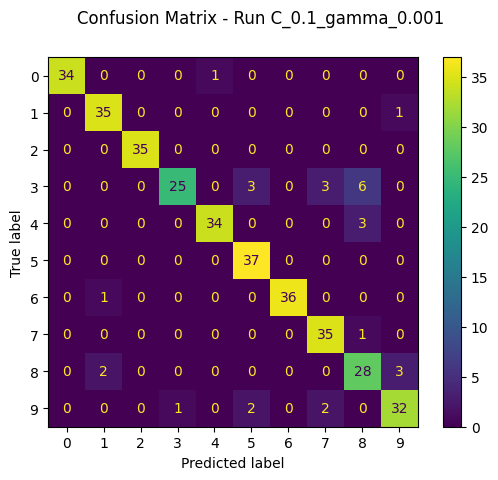

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_0.1_gamma_0.01 in experiment 2 with SVC params:
{ 'C': 0.1,
  'gamma': 0.01,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_0.1_gamma_0.01
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 0.1,
  'gamma': 0.01,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      1.000     0.167     0.286        36
           2      0.000     0.000     0.000        35
           3      0.105     1.000     0.189        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

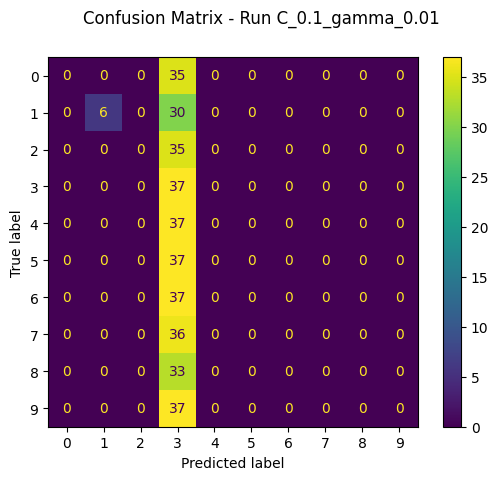

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_0.1_gamma_0.1 in experiment 2 with SVC params:
{ 'C': 0.1,
  'gamma': 0.1,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_0.1_gamma_0.1
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 0.1,
  'gamma': 0.1,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      0.000     0.000     0.000        36
           2      0.000     0.000     0.000        35
           3      0.103     1.000     0.186        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000     0

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

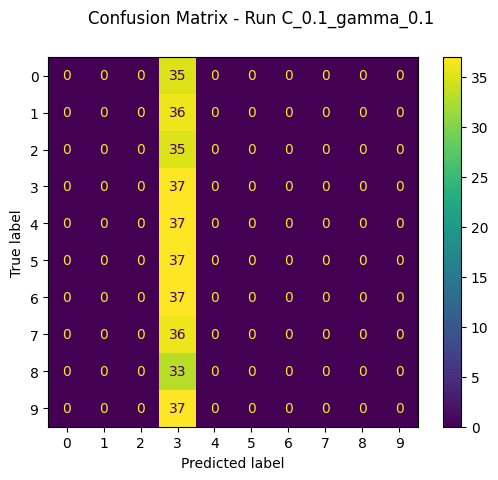

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_0.1_gamma_1 in experiment 2 with SVC params:
{ 'C': 0.1,
  'gamma': 1,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_0.1_gamma_1
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 0.1,
  'gamma': 1,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      0.837     1.000     0.911        36
           2      0.000     0.000     0.000        35
           3      0.117     1.000     0.209        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000     0.000    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

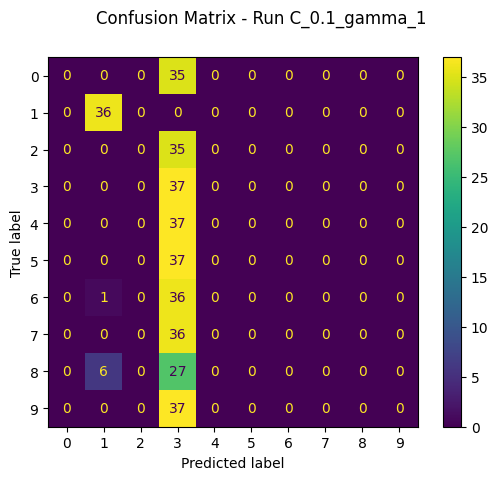

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_0.1_gamma_10 in experiment 2 with SVC params:
{ 'C': 0.1,
  'gamma': 10,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_0.1_gamma_10
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 0.1,
  'gamma': 10,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      0.000     0.000     0.000        36
           2      0.000     0.000     0.000        35
           3      0.103     1.000     0.186        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000     0.000

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

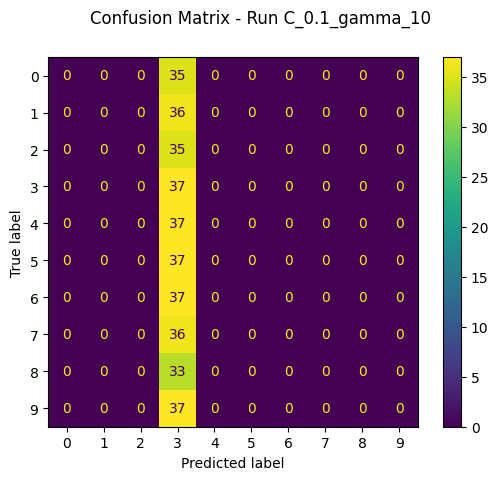

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_1.0_gamma_0.001 in experiment 2 with SVC params:
{ 'C': 1.0,
  'gamma': 0.001,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_1.0_gamma_0.001
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 1.0,
  'gamma': 0.001,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.971     0.986        35
           1      0.973     1.000     0.986        36
           2      1.000     1.000     1.000        35
           3      0.968     0.811     0.882        37
           4      0.971     0.919     0.944        37
           5      0.925     1.000     0.961        37
           6      1.000     1.000     1.000        37
           7      0.973     1.0

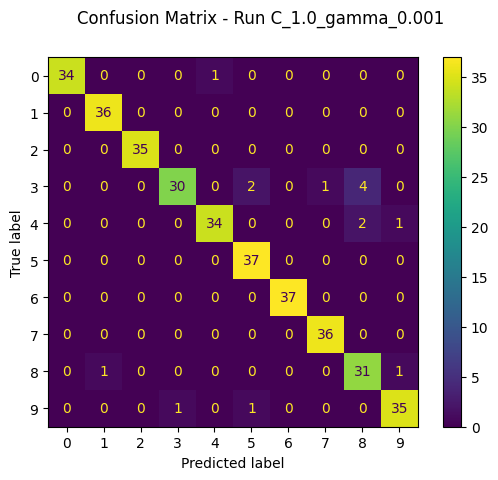

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_1.0_gamma_0.01 in experiment 2 with SVC params:
{ 'C': 1.0,
  'gamma': 0.01,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_1.0_gamma_0.01
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 1.0,
  'gamma': 0.01,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.714     0.833        35
           1      1.000     0.694     0.820        36
           2      1.000     0.629     0.772        35
           3      1.000     0.541     0.702        37
           4      1.000     0.757     0.862        37
           5      1.000     0.838     0.912        37
           6      1.000     0.568     0.724        37
           7      1.000     0.667  

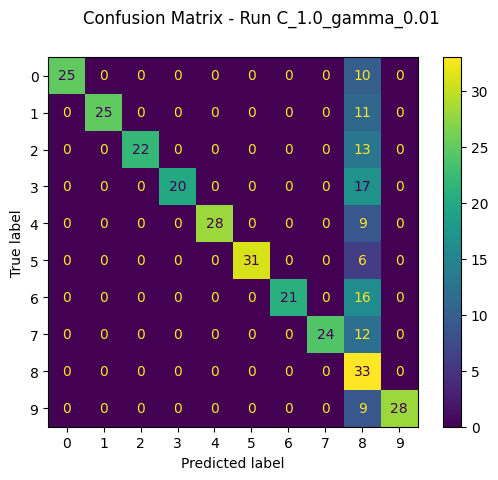

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_1.0_gamma_0.1 in experiment 2 with SVC params:
{ 'C': 1.0,
  'gamma': 0.1,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_1.0_gamma_0.1
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 1.0,
  'gamma': 0.1,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      1.000     0.056     0.105        36
           2      0.000     0.000     0.000        35
           3      0.103     1.000     0.187        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000     0

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

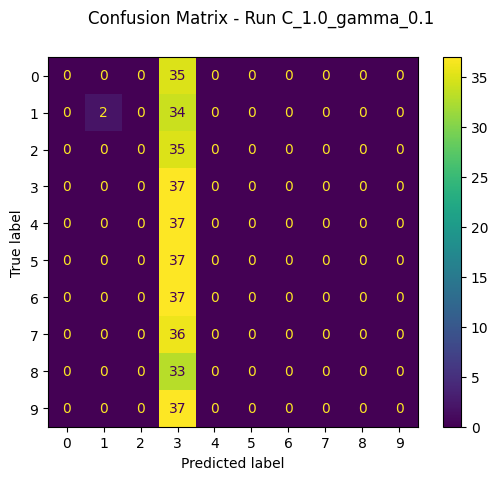

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_1.0_gamma_1 in experiment 2 with SVC params:
{ 'C': 1.0,
  'gamma': 1,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_1.0_gamma_1
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 1.0,
  'gamma': 1,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      0.000     0.000     0.000        36
           2      0.000     0.000     0.000        35
           3      0.103     1.000     0.186        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000     0.000    

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

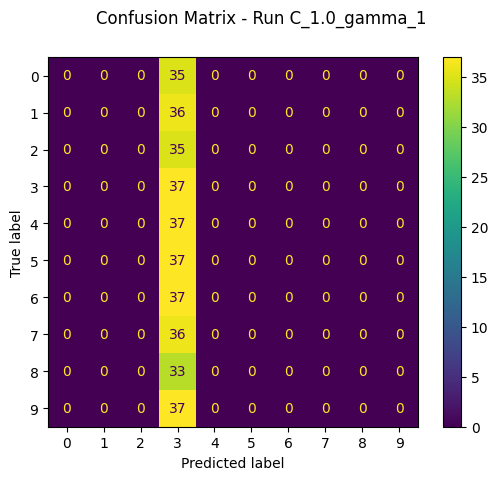

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_1.0_gamma_10 in experiment 2 with SVC params:
{ 'C': 1.0,
  'gamma': 10,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_1.0_gamma_10
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 1.0,
  'gamma': 10,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      0.000     0.000     0.000        36
           2      0.000     0.000     0.000        35
           3      0.103     1.000     0.186        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000     0.000

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

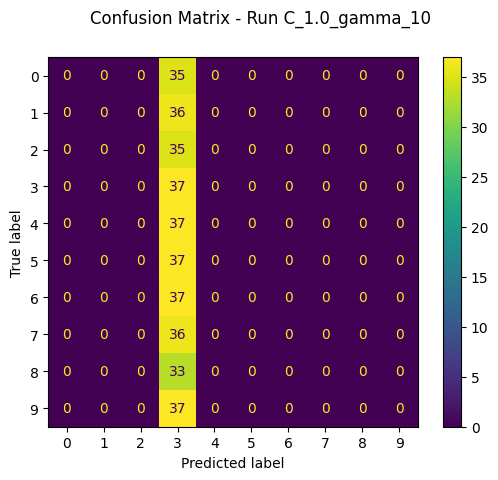

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_10.0_gamma_0.001 in experiment 2 with SVC params:
{ 'C': 10.0,
  'gamma': 0.001,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_10.0_gamma_0.001
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 10.0,
  'gamma': 0.001,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.971     0.986        35
           1      0.973     1.000     0.986        36
           2      1.000     1.000     1.000        35
           3      1.000     0.838     0.912        37
           4      0.971     0.919     0.944        37
           5      0.925     1.000     0.961        37
           6      1.000     1.000     1.000        37
           7      1.000    

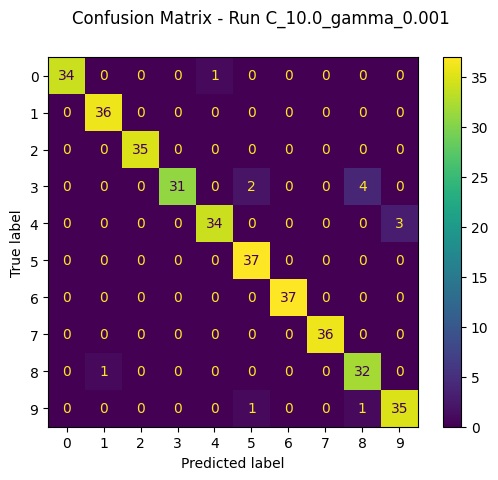

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_10.0_gamma_0.01 in experiment 2 with SVC params:
{ 'C': 10.0,
  'gamma': 0.01,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_10.0_gamma_0.01
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 10.0,
  'gamma': 0.01,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      1.000     0.714     0.833        35
           1      1.000     0.694     0.820        36
           2      1.000     0.657     0.793        35
           3      1.000     0.541     0.702        37
           4      1.000     0.757     0.862        37
           5      1.000     0.865     0.928        37
           6      1.000     0.568     0.724        37
           7      1.000     0.6

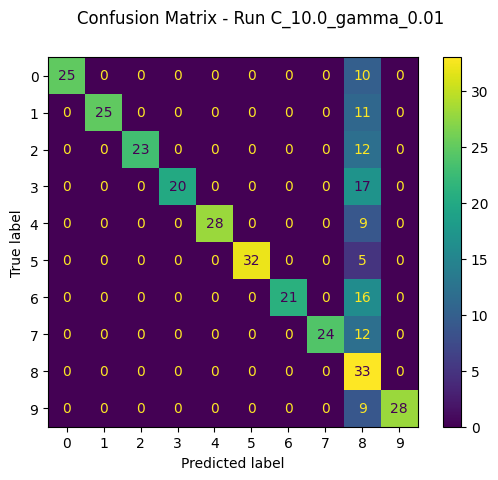

Recording run params, metrics, and artifacts to MLflow...


/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Finishing recording.
******************************************
******************************************
Starting run C_10.0_gamma_0.1 in experiment 2 with SVC params:
{ 'C': 10.0,
  'gamma': 0.1,
  'kernel': 'rbf',
  'random_state': 470}
Initializing model...
Training model...
Predicting using trained model...
Finished predictions.
Run: C_10.0_gamma_0.1
Random seed: 470
Classifier type: sklearn.svm.SVC
Specified classifier params:
{ 'C': 10.0,
  'gamma': 0.1,
  'kernel': 'rbf',
  'random_state': 470}
Classification report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        35
           1      1.000     0.056     0.105        36
           2      0.000     0.000     0.000        35
           3      0.103     1.000     0.187        37
           4      0.000     0.000     0.000        37
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000        37
           7      0.000     0.000  

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classificat

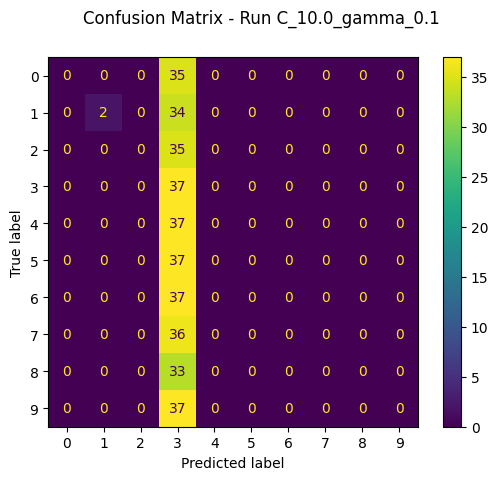

Recording run params, metrics, and artifacts to MLflow...


FileNotFoundError: [Errno 2] No such file or directory: 'confusion_matrix_run_C_10.0_gamma_0.1.png'

In [24]:
# perform a hyperparam sweep to find the best regularization and gamma for an SVC with a radial basis function kernel
random_seed = 470
regularizations = [0.1, 1.0, 10.0, 100.0]
gammas = [0.001, 0.01, 0.1, 1, 10]
for regularization, gamma in product(regularizations, gammas):
    svc_param_kwargs = {
        "kernel": "rbf",
        "C": regularization,
        "gamma": gamma,
    }
    # each call creates a "run" in MLflow and records metrics/artifacts about that run
    create_run_svm_classify(
        experiment_id,
        train_x,
        train_y,
        test_x,
        test_y,
        random_seed,
        svc_param_kwargs=svc_param_kwargs,
        run_name=f"C_{regularization}_gamma_{gamma}",
    )

In [ ]:
print("You created your first experiment!")
print(f"Go to the Experiments UI and click on the {experiment_name} experiment to compare runs.")
print("You can also explore and share run artifacts (e.g. overview and confusion matrix).")